In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from PIL import Image
from math import pi
import cv2
import math 
import pandas as pd

In [2]:
width = 22.5 # mm
resolution = 6000 #px
fs = round((width/ resolution), 4)
period = round(1 / fs, 3)

print(fs)
print(period)

0.0037
270.27


In [3]:
def sin(x, frequency, phase):
    return 0.5 + 0.5*np.sin(frequency * x*np.pi + phase)

In [5]:
def get_image(y):
    print(min(y),max(y))
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    data = Image.fromarray(x)
    plt.imshow(data)
    #plt.axis("off")
    plt.show()

In [6]:
def get_mat(y):
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    return x 

In [7]:
def discretization(freq, phase):
    height = 300
    y = []
    x = 0.0
    print(freq)
    while x < 1/fs * height:
        y0 = integrate.quad(lambda x: sin(x, freq, phase), x, x+1/fs)[0]/period
        y.append(round(y0,2))
        x += 1/fs

    get_image(y)
    return y 

0.0007400000000000001
0.01 0.99


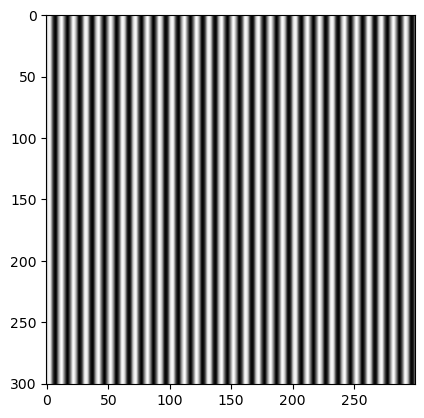

0.0012333333333333332
0.02 0.98


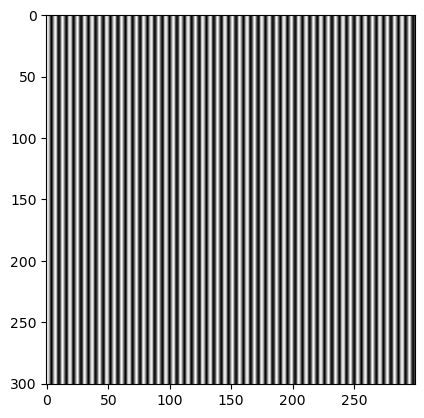

0.00185
0.18 0.82


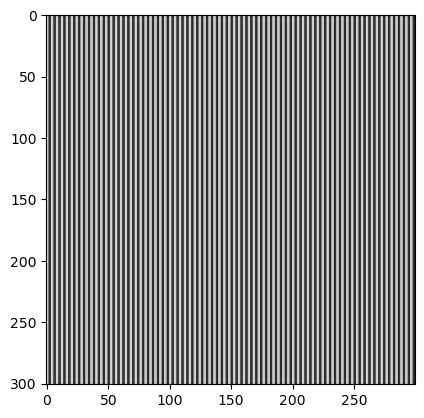

0.0037
0.18 0.82


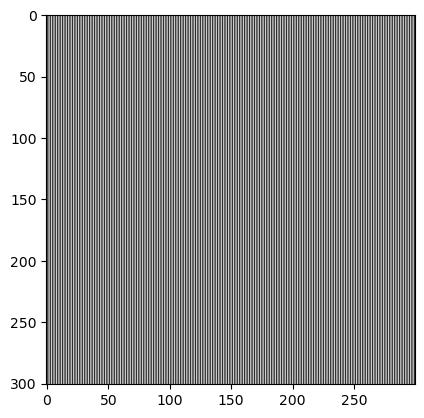

0.005217
0.32 0.68


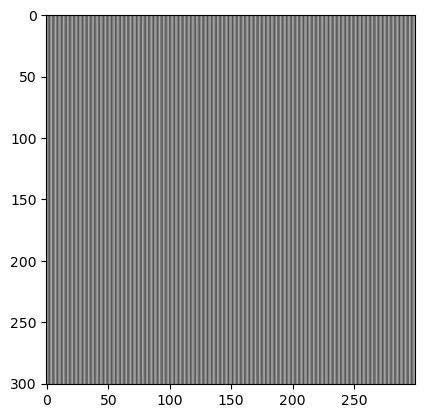

0.0074
0.5 0.5


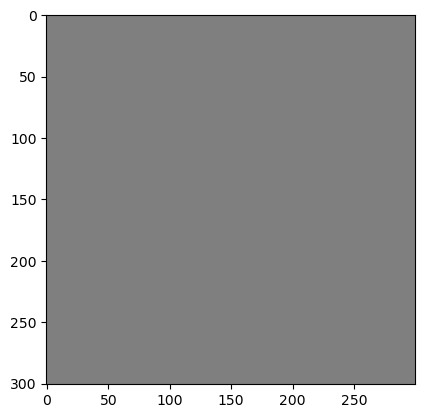

0.0111
0.39 0.61


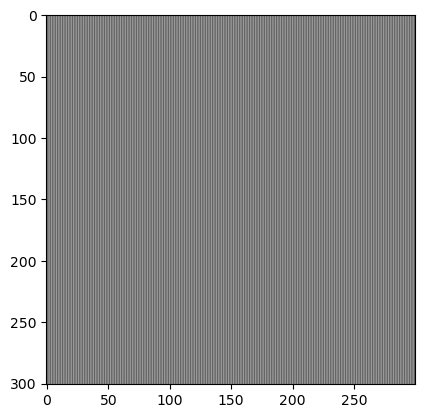

0.0148
0.5 0.5


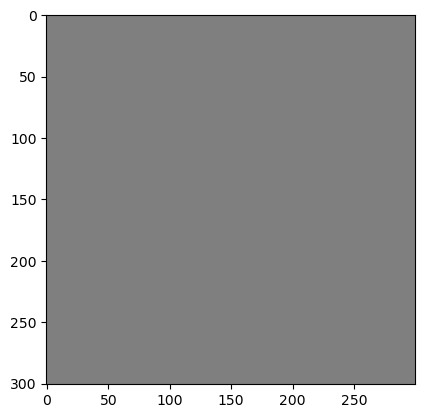

0.018500000000000003
0.44 0.56


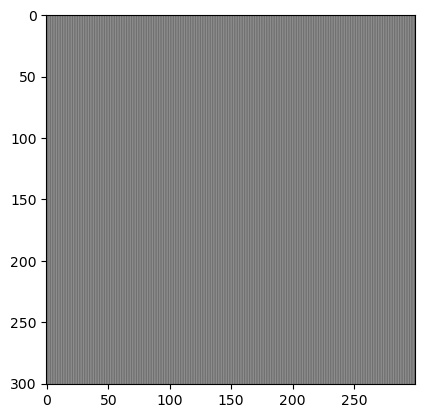

0.0222
0.5 0.5


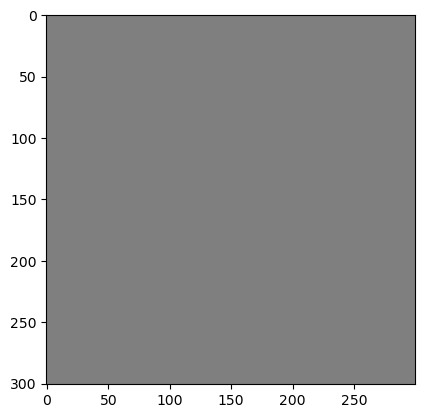

0.0259
0.45 0.55


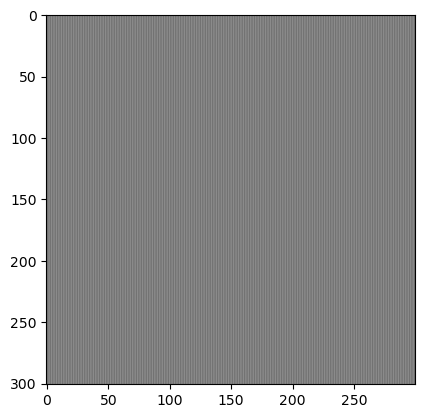

0.037000000000000005
0.5 0.5


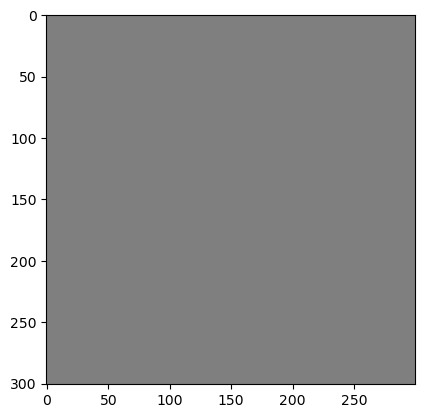

In [8]:
pars = [1/5, 1/3, 1/2, 1, 1.41, 2, 3, 4, 5, 6,7,10]
list_sample = []
for i, par  in enumerate(pars):
    list_sample.append(discretization(par*fs, 0))

0.0007400000000000001
0.02 0.98


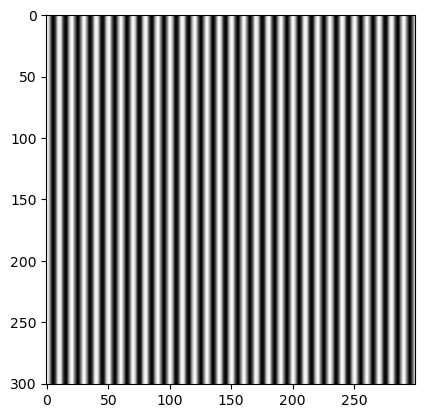

0.0012333333333333332
0.02 0.98


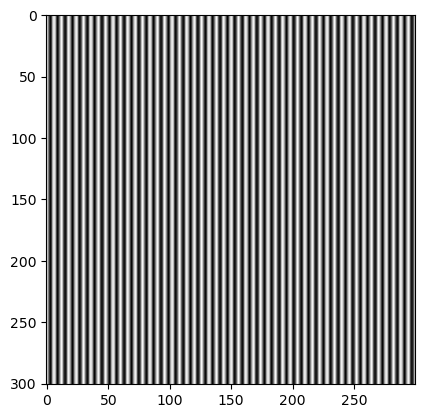

0.00185
0.06 0.94


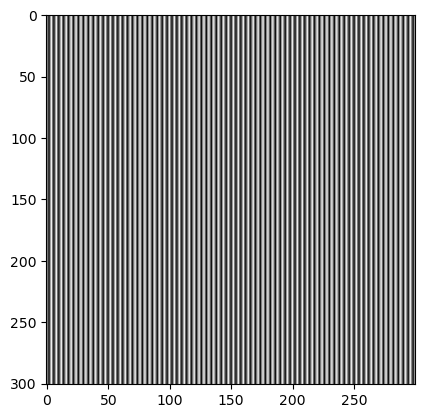

0.0037
0.33 0.67


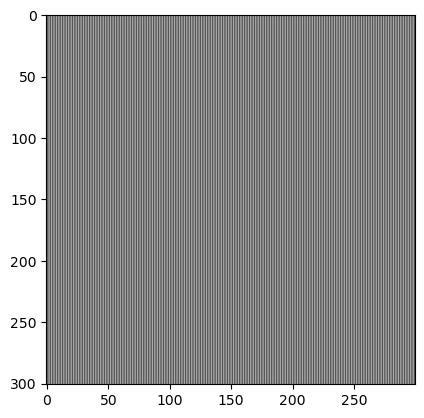

0.005217
0.32 0.68


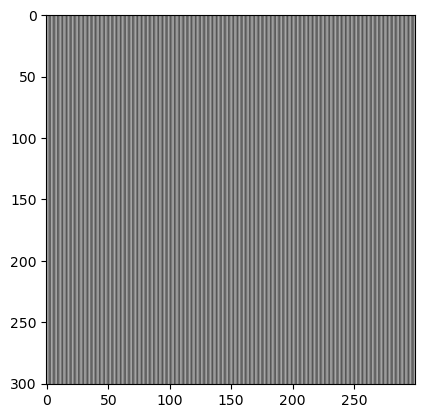

0.0074
0.5 0.5


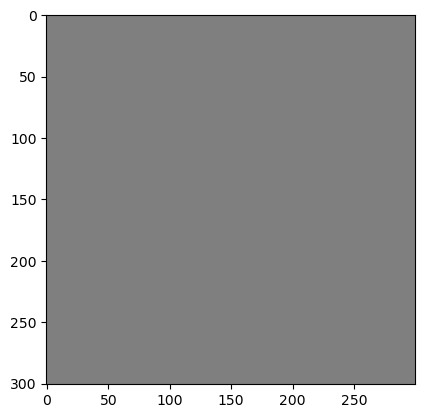

0.0111
0.44 0.56


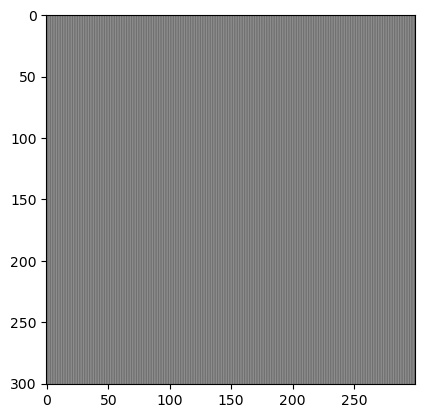

0.0148
0.5 0.5


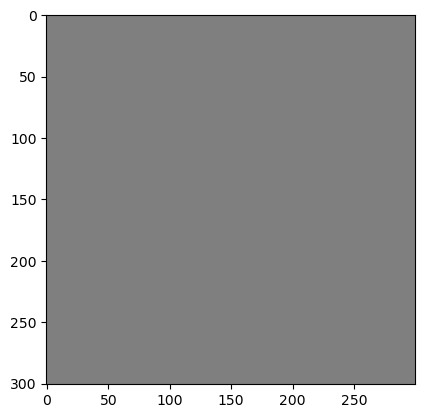

0.018500000000000003
0.47 0.53


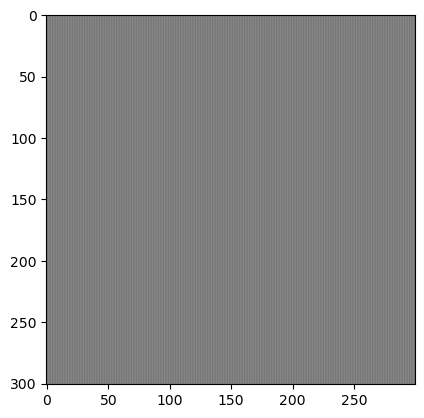

0.0222
0.5 0.5


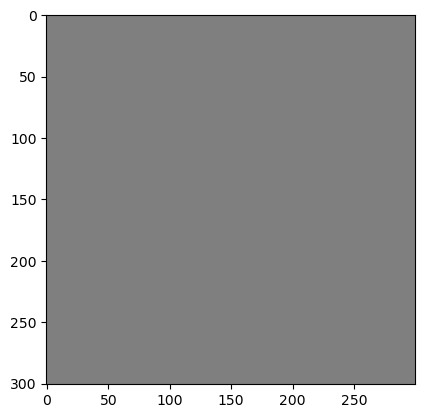

0.0259
0.48 0.52


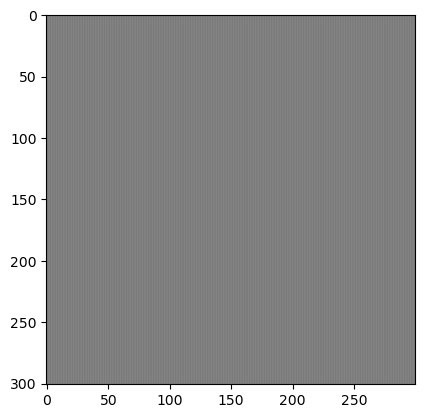

0.037000000000000005
0.5 0.5


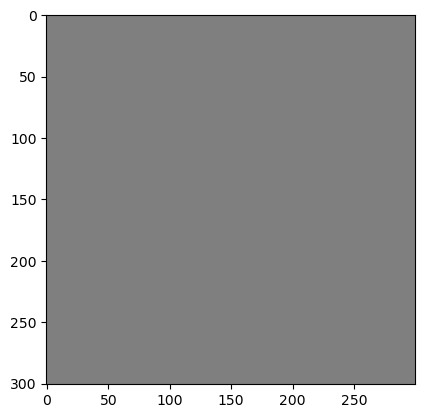

In [9]:
for i, par  in enumerate(pars):
    discretization(par*fs, 1)

In [10]:
# метрика MSE
def MSE(img1, img2):
    return np.mean((img1 - img2)**2)


In [11]:
# метрика PSNR
def PSNR(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = MSE(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [12]:
# метрика SSIM
def SSIM(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [13]:
def quantize_uniform(x, quant_min=0.0, quant_max=1.0, quant_level=2):
    
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant


In [14]:
lvl_quant = [2, 8, 32, 64, 128, 256]

In [15]:
# 1 изображение 
def get_statistics(im, check = True, quant_min=0.1, quant_max=.9):
    MSE_ = ['MSE']
    PSNR_ = ['PSNR']
    SSIM_ = ['SSIM']
    f  = plt.figure(figsize=(60,60))
    # отображение изображений
    for i, lvl in enumerate(lvl_quant):
        img = quantize_uniform(np.array(im),quant_min=quant_min, quant_max=quant_max, quant_level=lvl)
        MSE_.append(MSE(np.array(im), np.array(img)))
        PSNR_.append(PSNR(np.array(im), np.array(img)))
        SSIM_.append(SSIM(np.array(im), np.array(img)))

        f.add_subplot(1,13, i+1)
        plt.grid(False)
        if check:
            plt.imshow(get_mat(img), cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
    # отображение метрик
    df = pd.DataFrame(({'func':[], 'LV_2': [], 'LV_8': [], 'LV_32': [],'LV_64': [], 'LV_128': [], 'LV_256': []}))
    df.loc[ len(df.index )] = MSE_
    df.loc[ len(df.index )] = PSNR_
    df.loc[ len(df.index )] = SSIM_
    plt.show()
    print(df)
    
    return df

C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


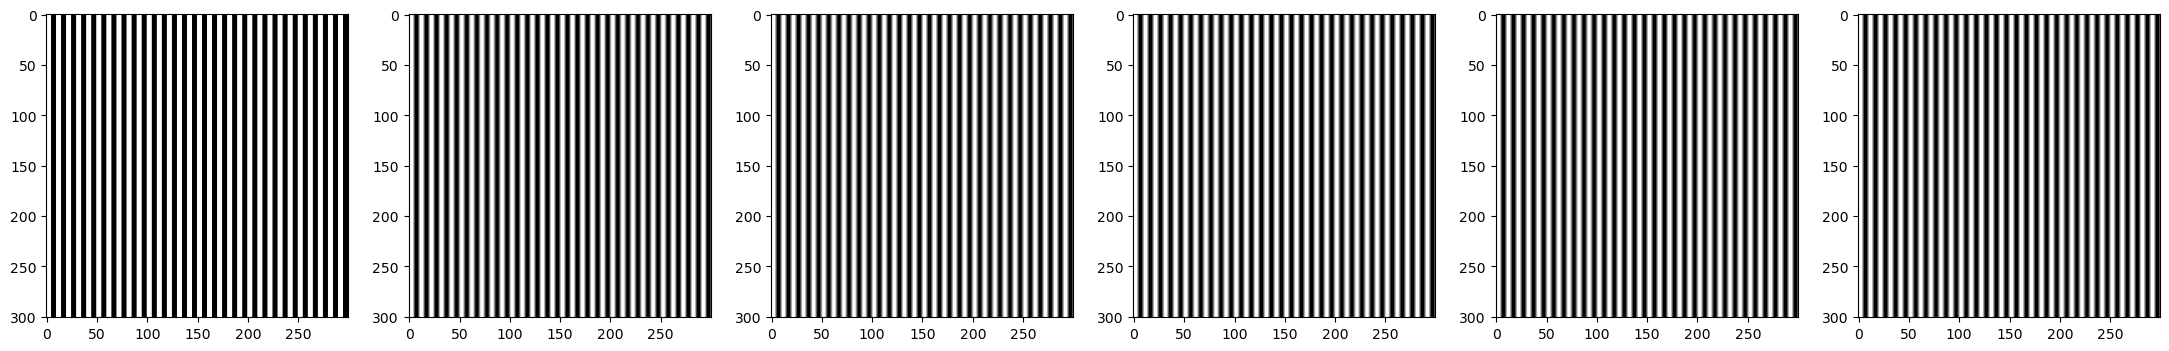

   func       LV_2       LV_8      LV_32      LV_64     LV_128     LV_256
0   MSE   0.026620   0.001804   0.001646   0.001626   0.001622   0.001620
1  PSNR  63.878723  75.569224  75.966467  76.018800  76.031500  76.034623
2  SSIM        NaN        NaN        NaN        NaN        NaN        NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


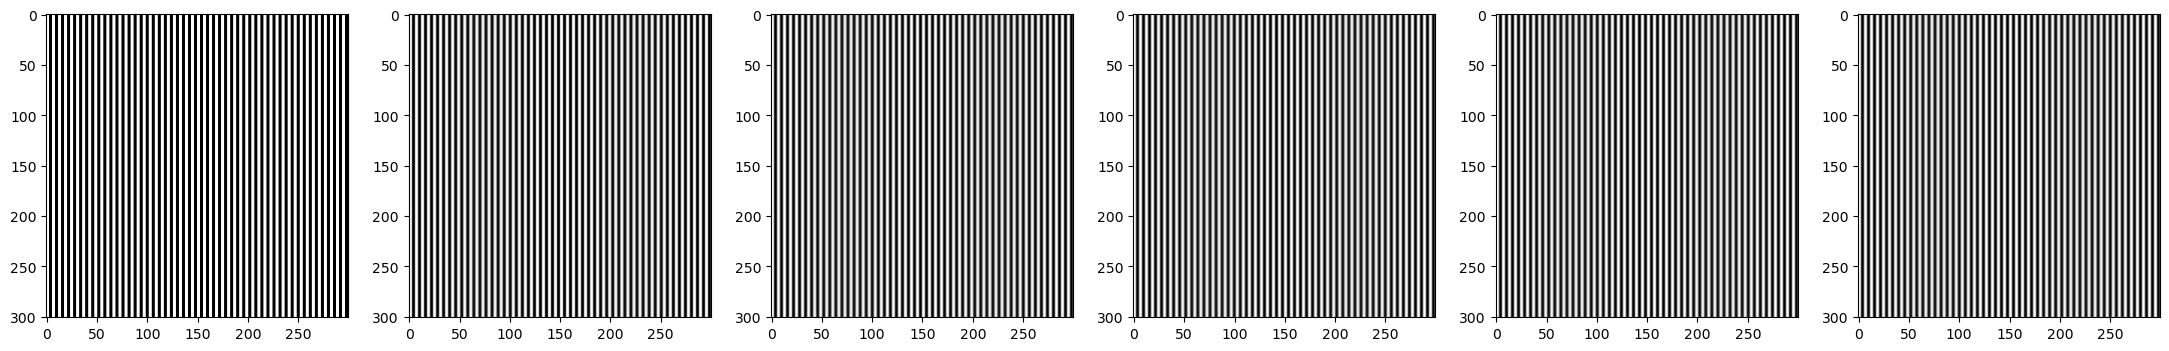

   func       LV_2       LV_8      LV_32      LV_64     LV_128     LV_256
0   MSE   0.019200   0.003527   0.002151   0.002151   0.002138   0.002133
1  PSNR  65.297791  72.657327  74.804213  74.805342  74.831609  74.840216
2  SSIM        NaN        NaN        NaN        NaN        NaN        NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


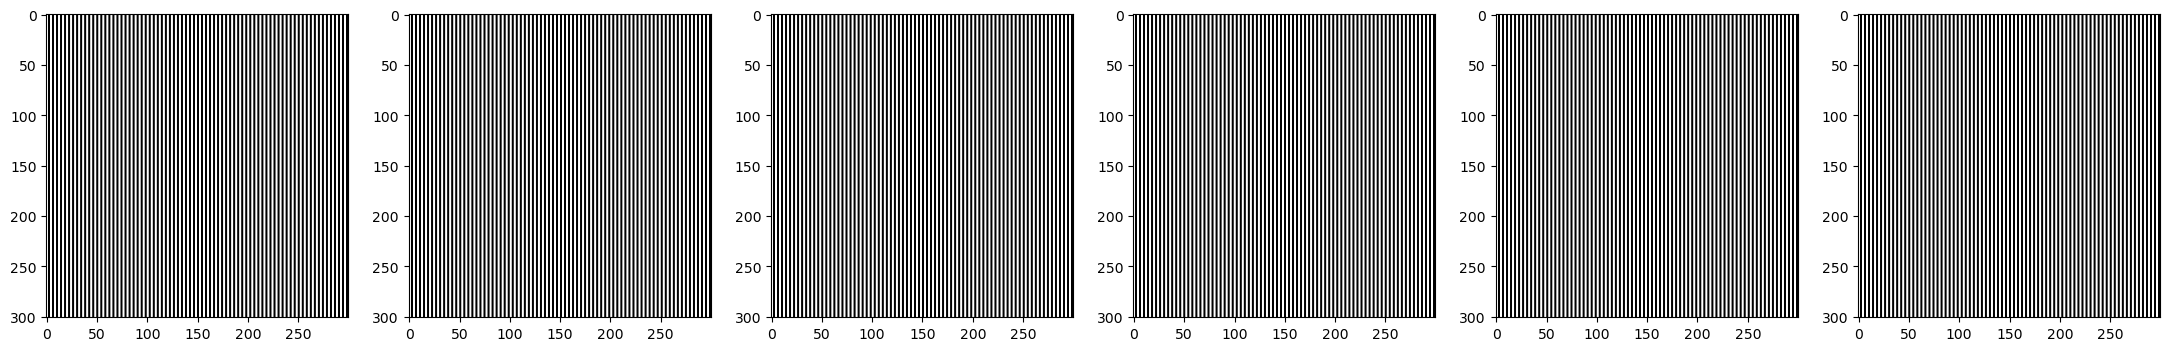

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.006400   0.001176   0.000007   0.000015    0.000004    0.000002
1  PSNR  70.069004  77.428540  99.896238  96.513390  102.602653  104.220407
2  SSIM        NaN        NaN        NaN        NaN         NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


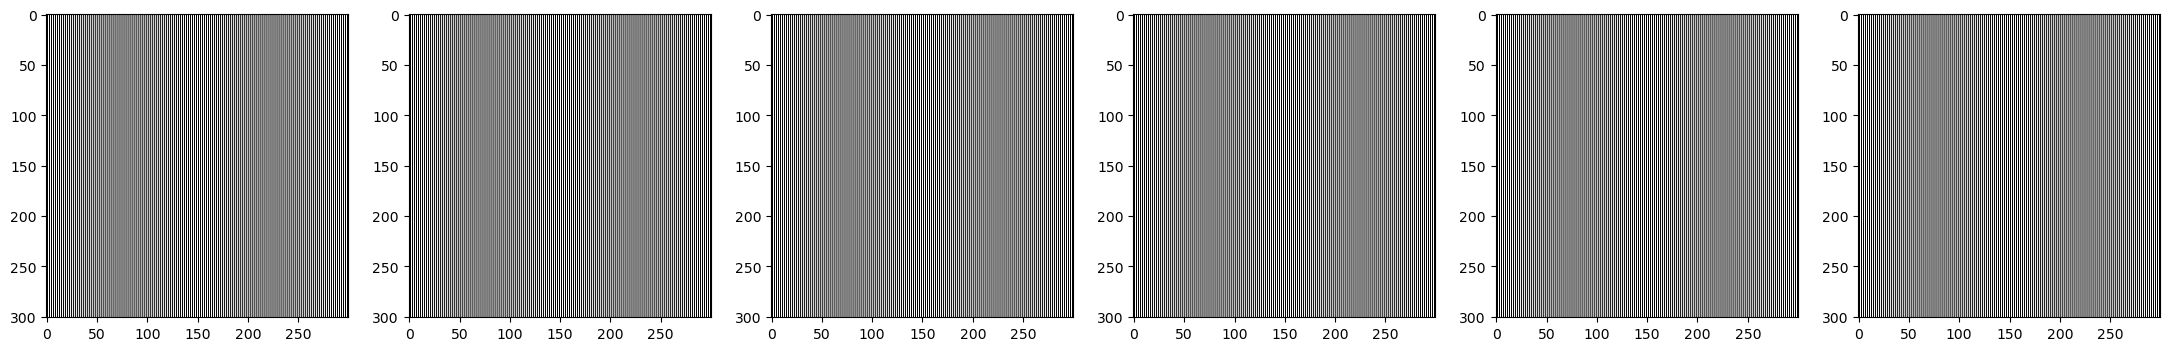

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.006400   0.001176   0.000007   0.000015    0.000004    0.000002
1  PSNR  70.069004  77.428540  99.896238  96.513390  102.602653  104.220407
2  SSIM        NaN        NaN        NaN        NaN         NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


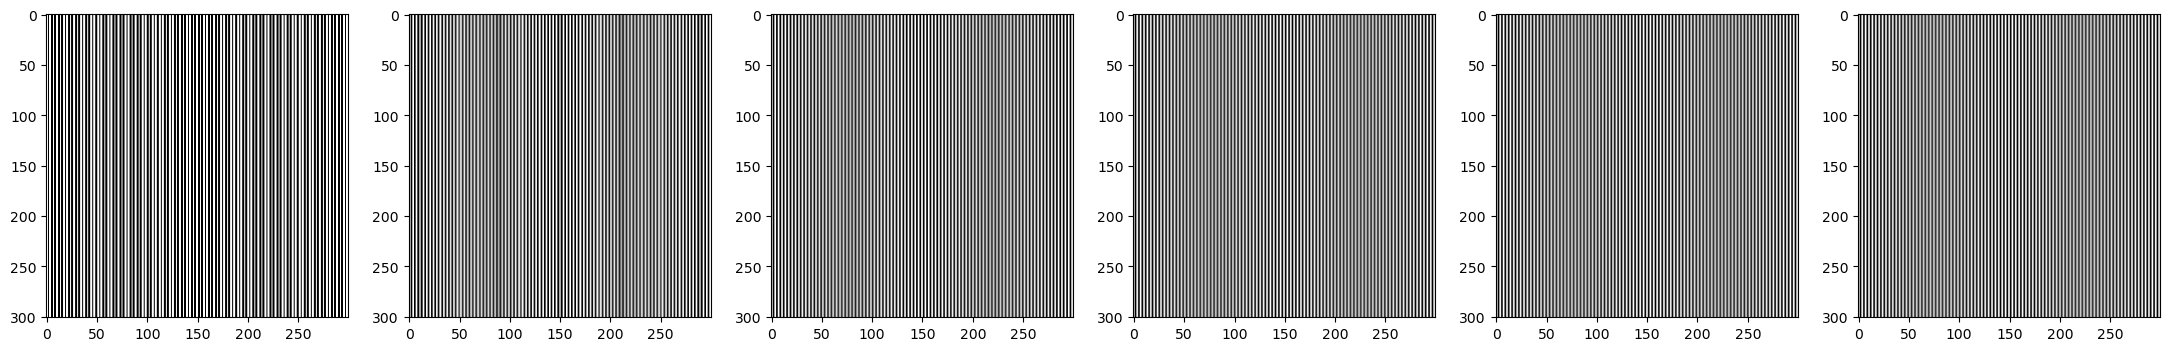

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.084574   0.000799   0.000067   0.000013    0.000003  8.173779e-07
1  PSNR  58.858435  79.103672  89.868235  96.947071  103.171729  1.090066e+02
2  SSIM        NaN        NaN        NaN        NaN         NaN           NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


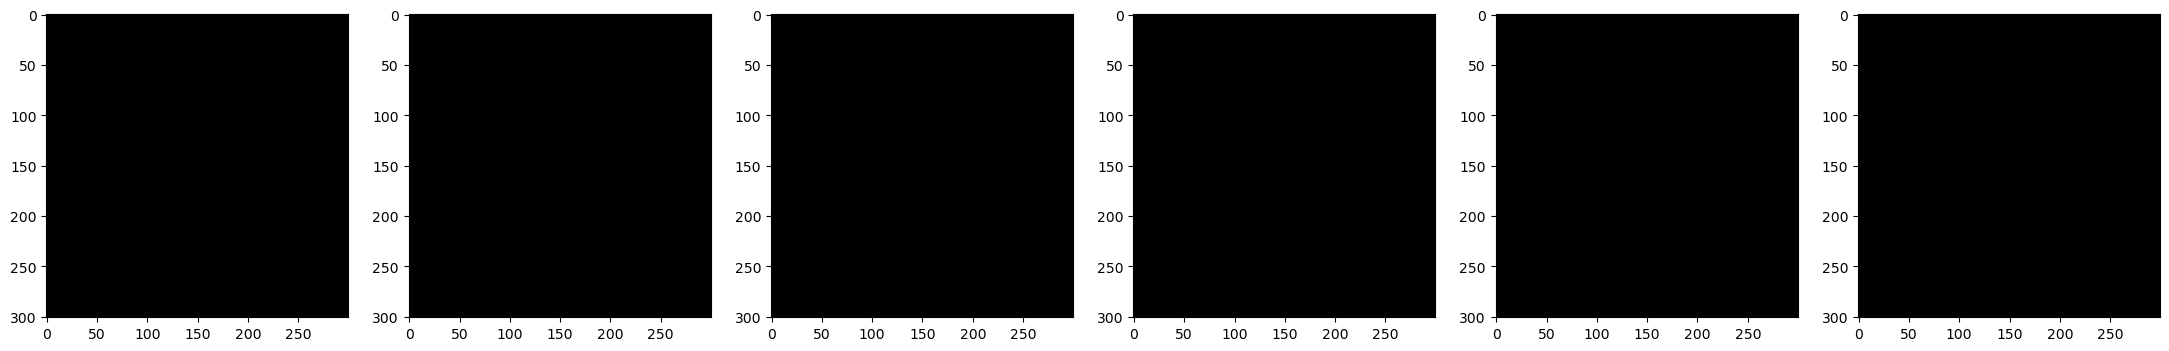

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM        NaN        NaN        NaN        NaN        NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


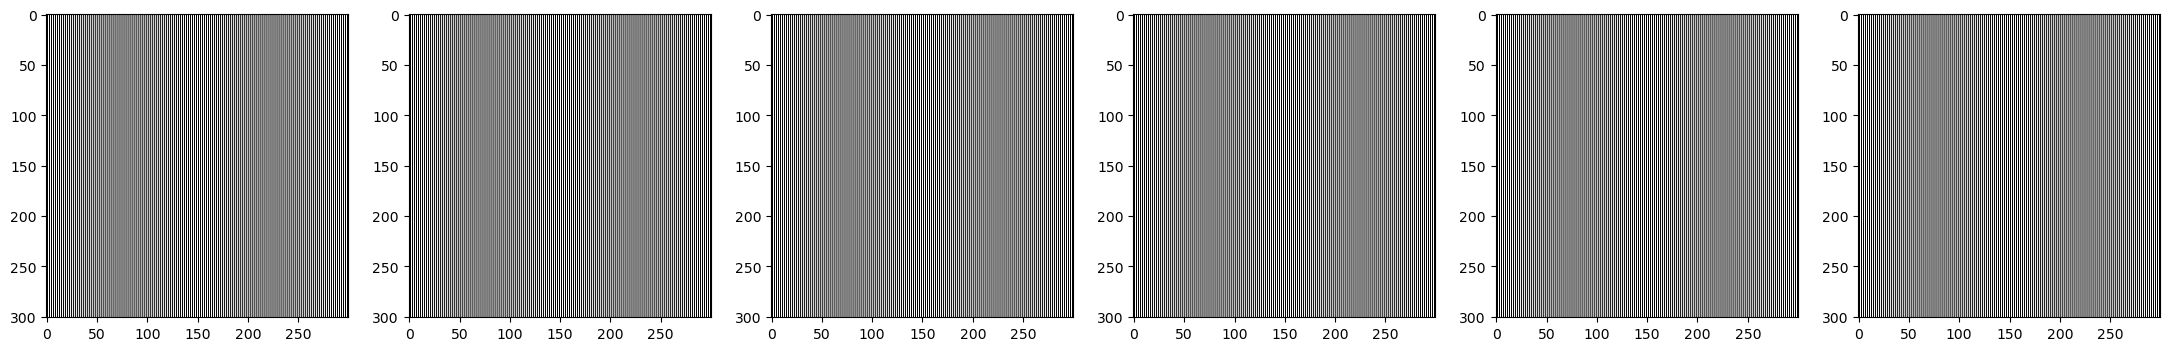

   func       LV_2       LV_8      LV_32       LV_64        LV_128      LV_256
0   MSE   0.084100   0.002794   0.000038    0.000004  5.580011e-08    0.000002
1  PSNR  58.882844  73.668730  92.382965  101.838748  1.206645e+02  105.380246
2  SSIM        NaN        NaN        NaN         NaN           NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


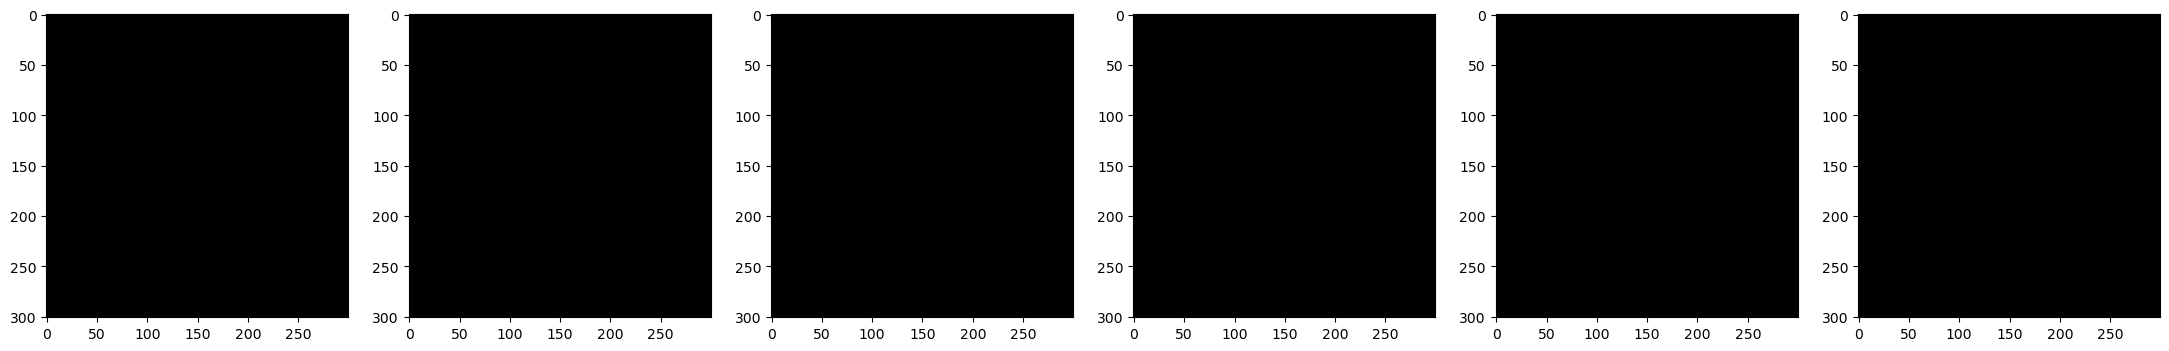

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM        NaN        NaN        NaN        NaN        NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


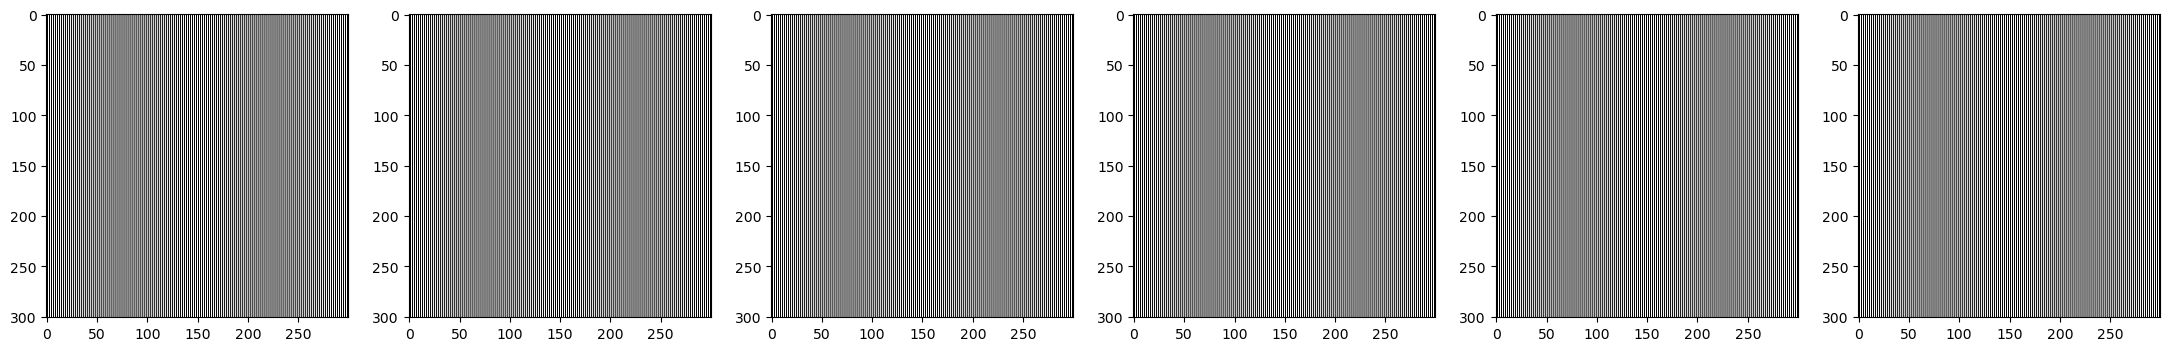

   func       LV_2       LV_8      LV_32      LV_64        LV_128      LV_256
0   MSE   0.115600   0.000008   0.000020   0.000008  2.480005e-08    0.000001
1  PSNR  57.501225  99.012164  95.035477  99.012164  1.241863e+02  106.719182
2  SSIM        NaN        NaN        NaN        NaN           NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


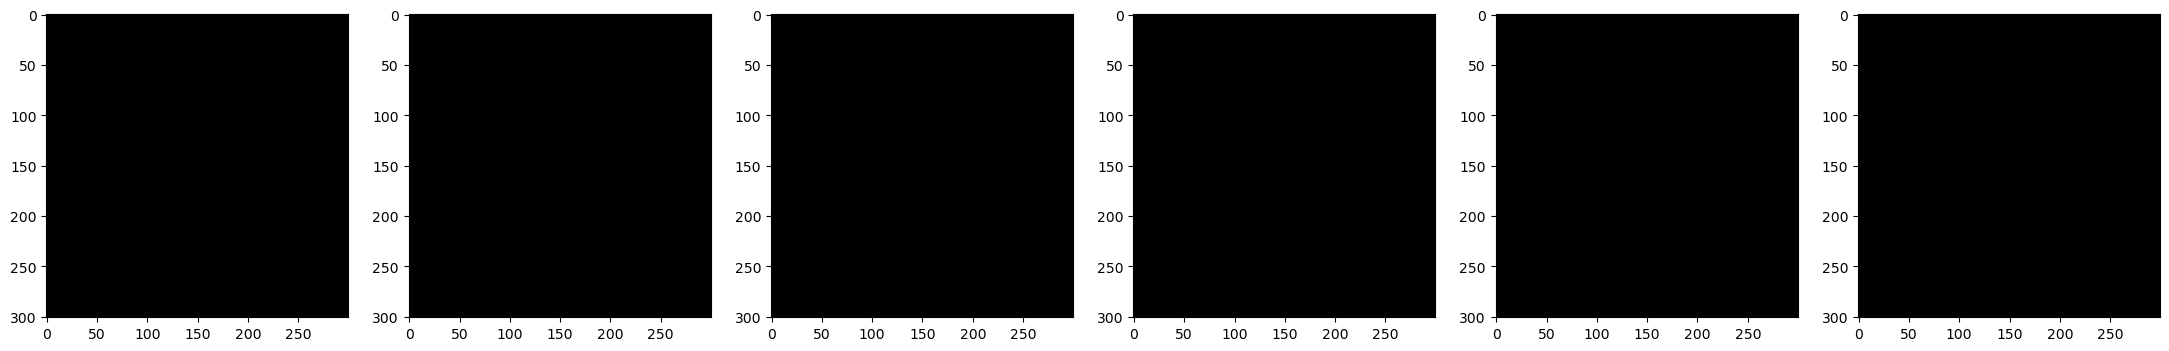

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM        NaN        NaN        NaN        NaN        NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


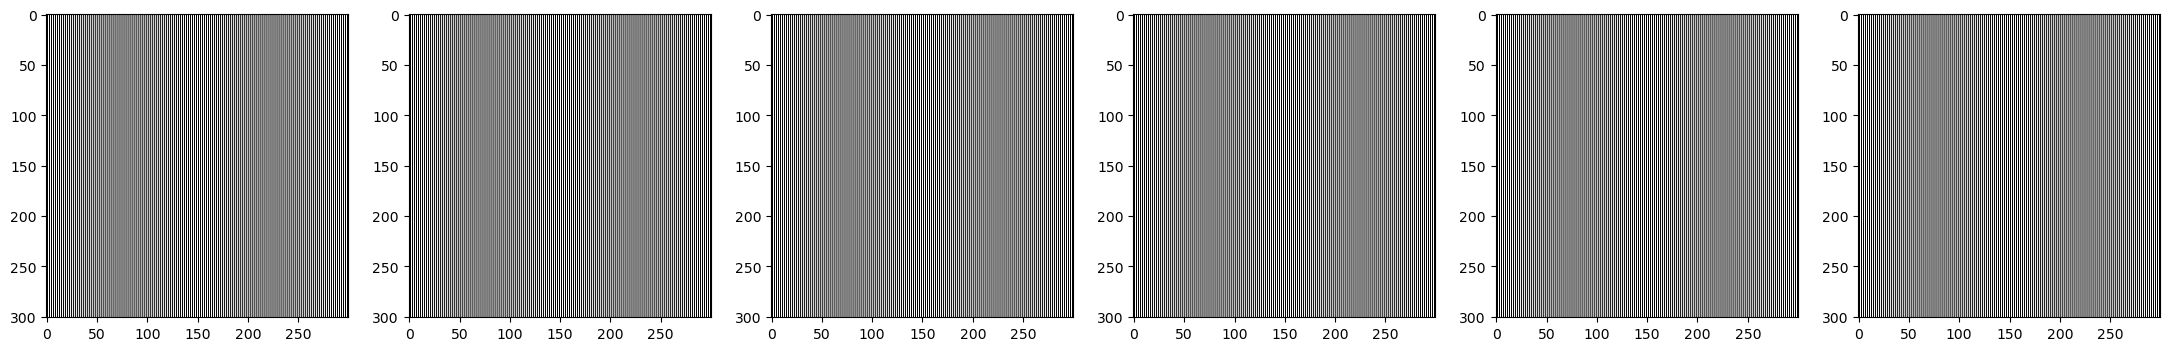

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.122500   0.000051   0.000127   0.000031   0.000008    0.000002
1  PSNR  57.249443  91.053364  87.076677  93.236254  99.325517  105.380246
2  SSIM        NaN        NaN        NaN        NaN        NaN         NaN


C:\Users\gongn\AppData\Local\Temp\ipykernel_9364\207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
c:\Users\gongn\miniconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


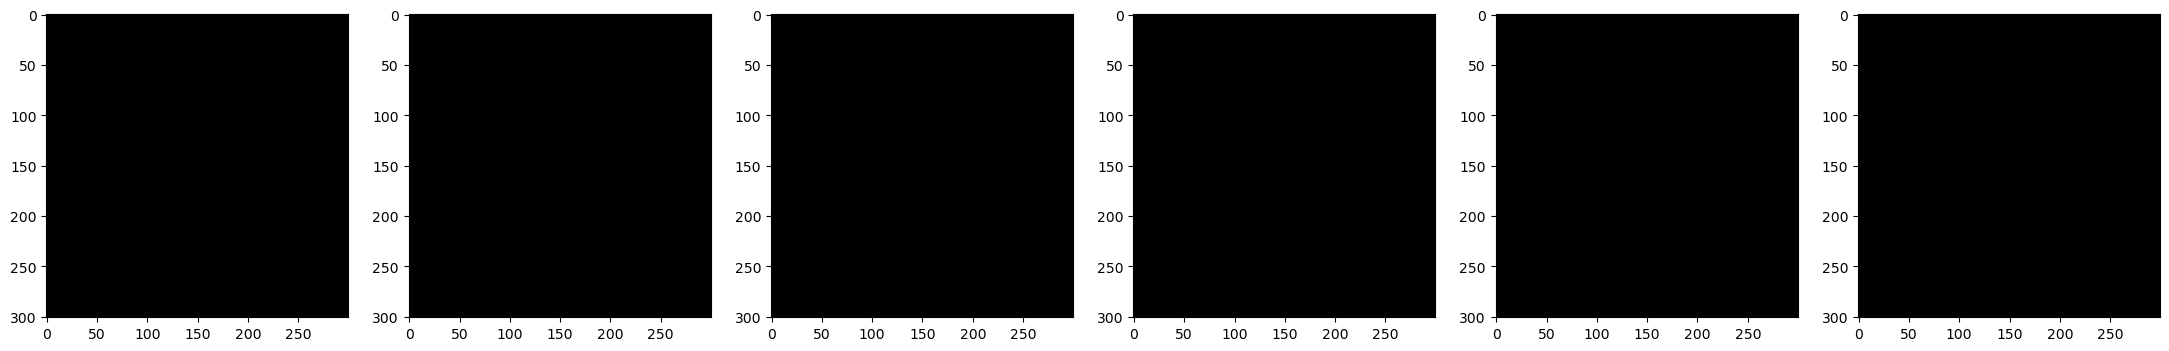

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM        NaN        NaN        NaN        NaN        NaN         NaN


In [16]:
list_df = []
for im in list_sample:
    list_df.append(get_statistics(im))

In [66]:
def quantize_nonuniform_mu(x, mu=255.0, quant_level=256):
    def encoding_mu_law(v, mu=255.0):

        v_encode = np.sign(v) * (np.log(1.0 + mu * np.abs(v)) / np.log(1.0 + mu))
        return v_encode

    def decoding_mu_law(v, mu=255.0):
        
        v_decode = np.sign(v) * (1.0 / mu) * ((1.0 + mu)**np.abs(v) - 1.0)
        return v_decode

    x_en = encoding_mu_law(x, mu=mu)
    x_en_quant = quantize_uniform(x_en, quant_min=-1, quant_max=1, quant_level=quant_level)
    x_quant = decoding_mu_law(x_en_quant, mu=mu)
    return x_quant

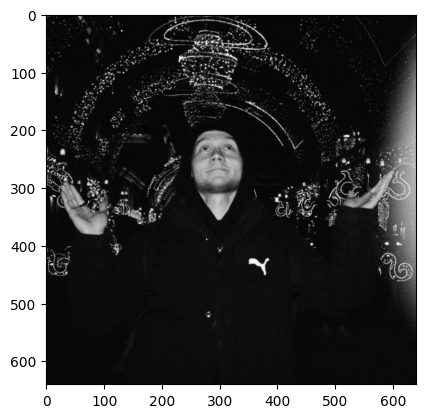

In [64]:
image_path = '/Users/dimka777/Documents/Магистратура/Mag_2_semester/ImageProcessing/PW_3/images/image_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap = 'gray')

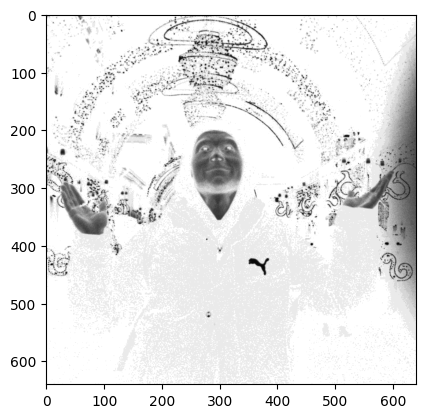

In [88]:
df_img=quantize_nonuniform_mu(image,mu = 255, quant_level =128)
plt.imshow(df_img, cmap ='gray')

/var/folders/9c/5j8yw361331_8dw2djv7y_sh0000gn/T/ipykernel_87486/207283151.py:22: RuntimeWarning: Mean of empty slice.
  return ssim_map.mean()
/Users/dimka777/opt/anaconda3/envs/Mag/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


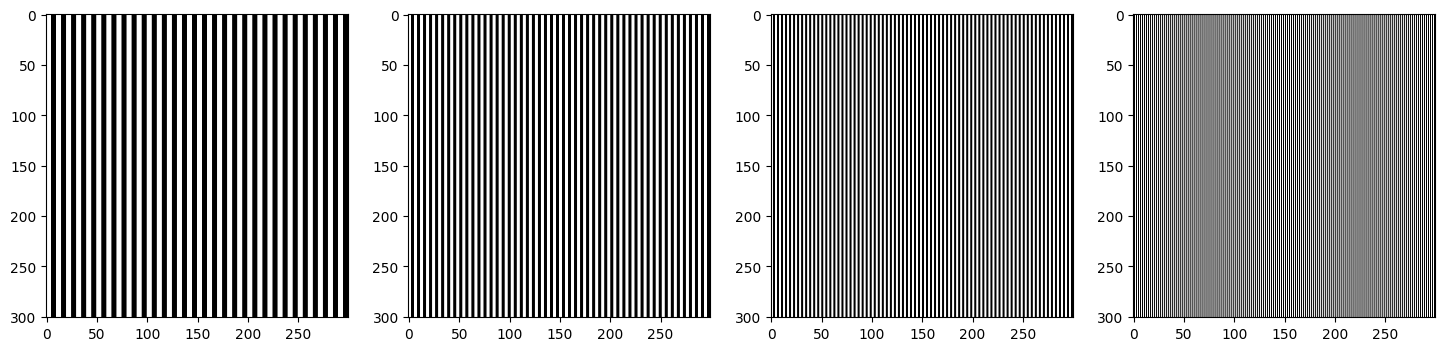

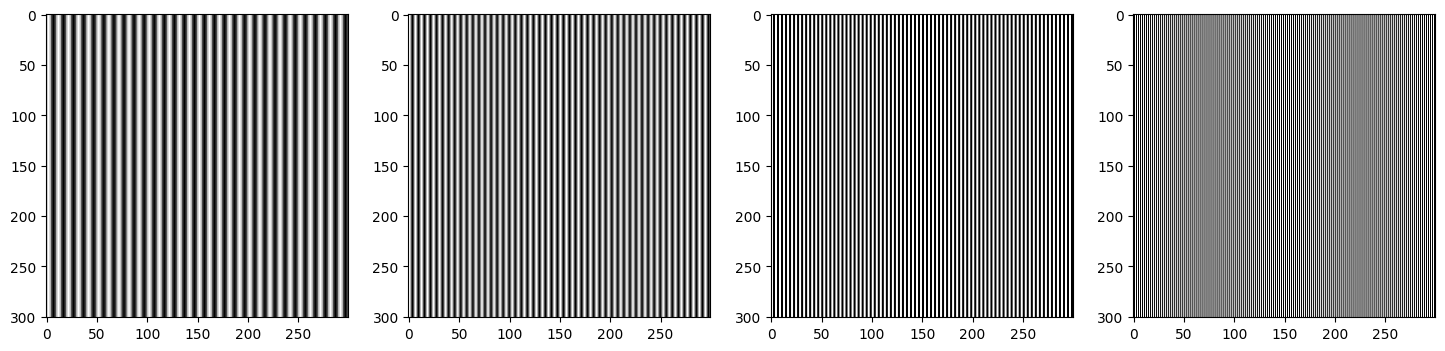

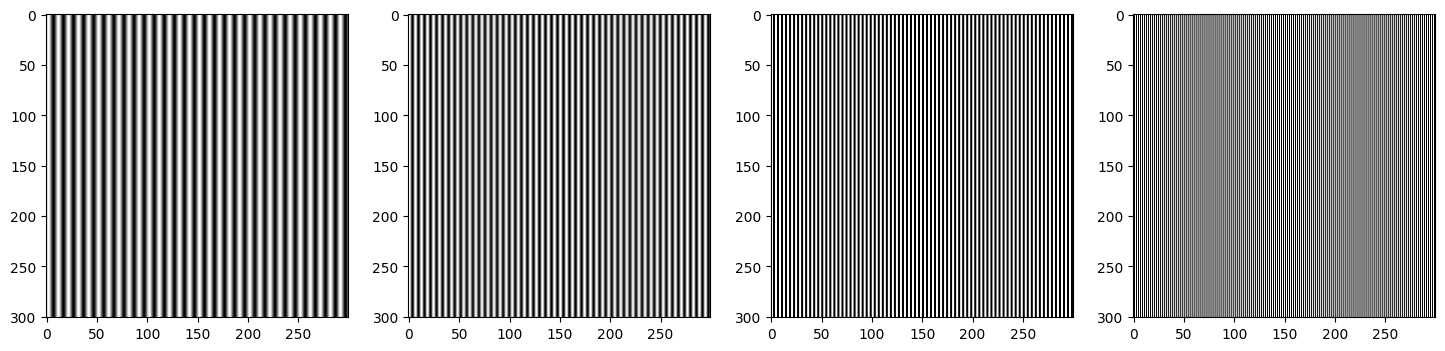

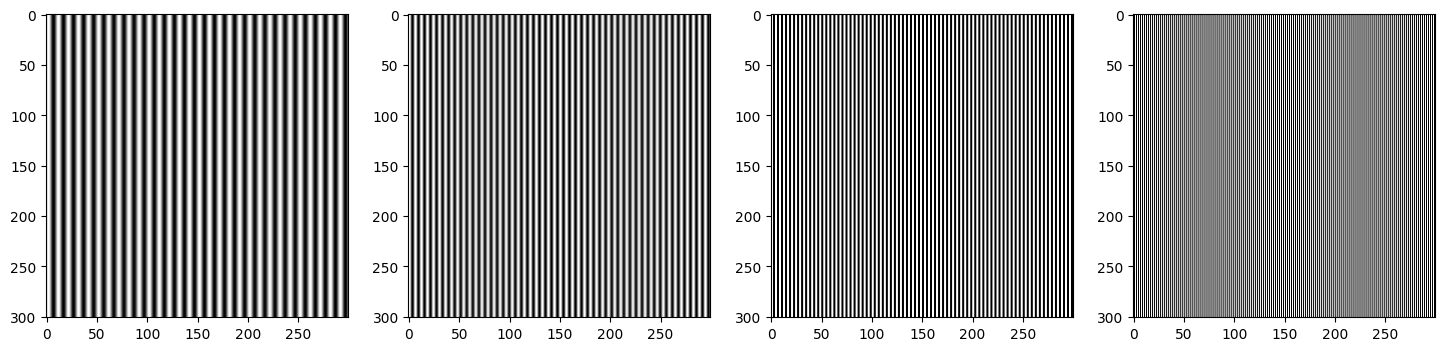

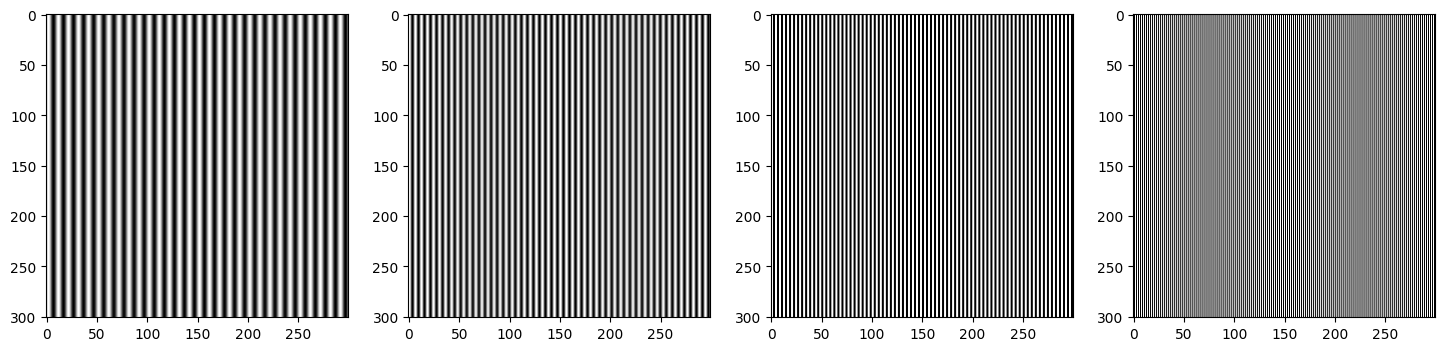

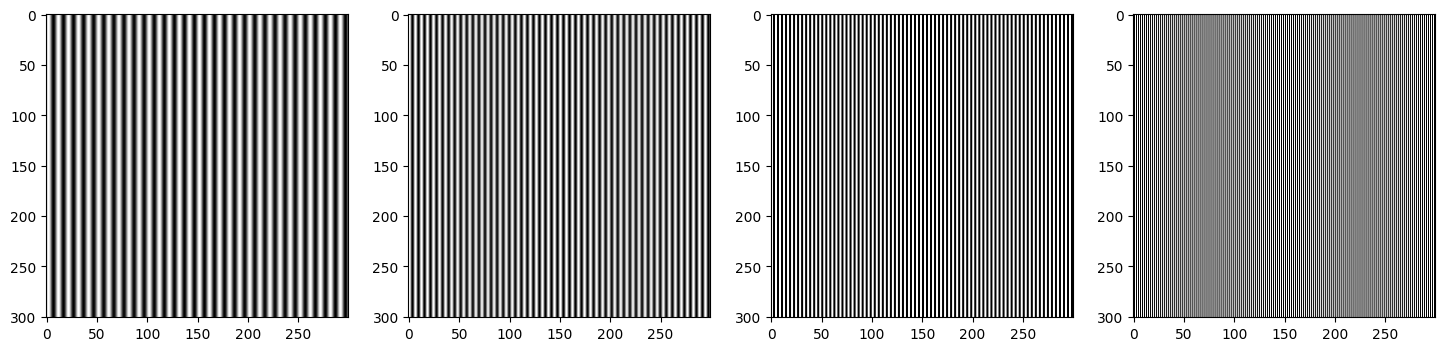

In [23]:
for lvl in lvl_quant:
    f  = plt.figure(figsize=(60,60))
    for j,im in enumerate(list_sample):
        img = quantize_uniform(np.array(im),quant_min=0.0, quant_max=1.0, quant_level=lvl)
        MSE_.append(MSE(np.array(im), np.array(img)))
        PSNR_.append(PSNR(np.array(im), np.array(img)))
        SSIM_.append(SSIM(np.array(im), np.array(img)))
        
        if j<4:
            f.add_subplot(1,13, j+1)
            plt.grid(False)
            plt.imshow(get_mat(img), cmap='gray')

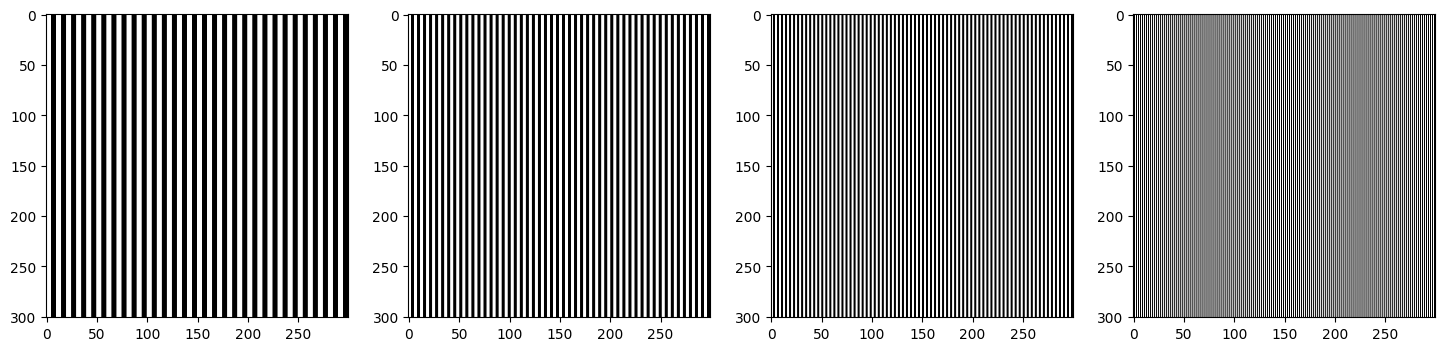

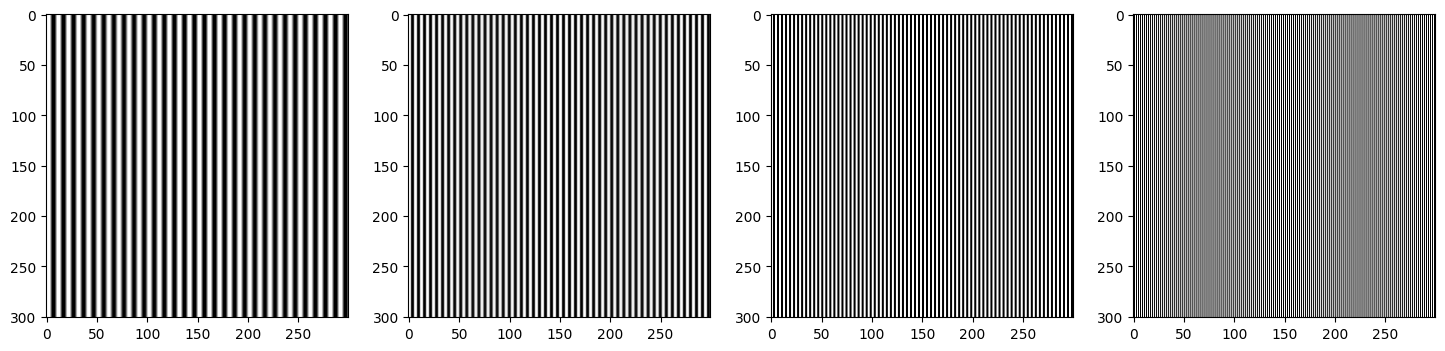

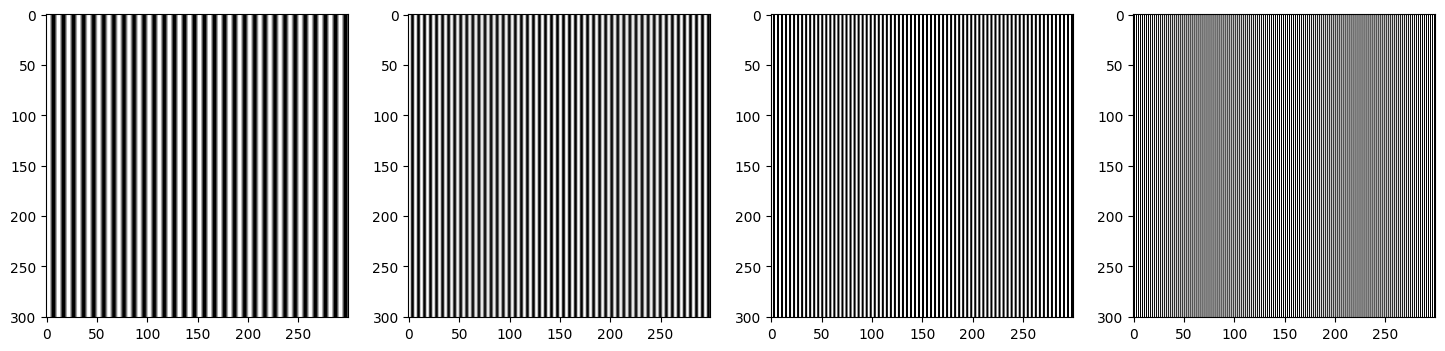

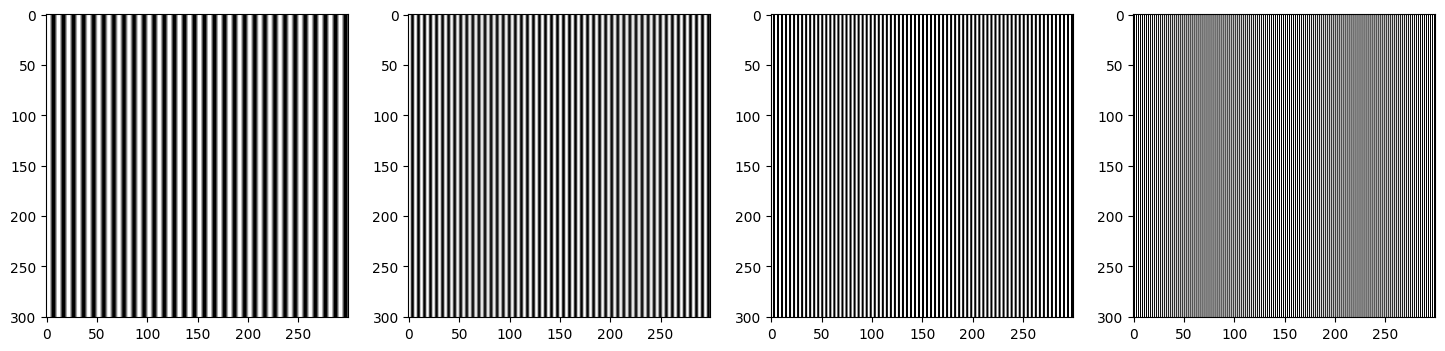

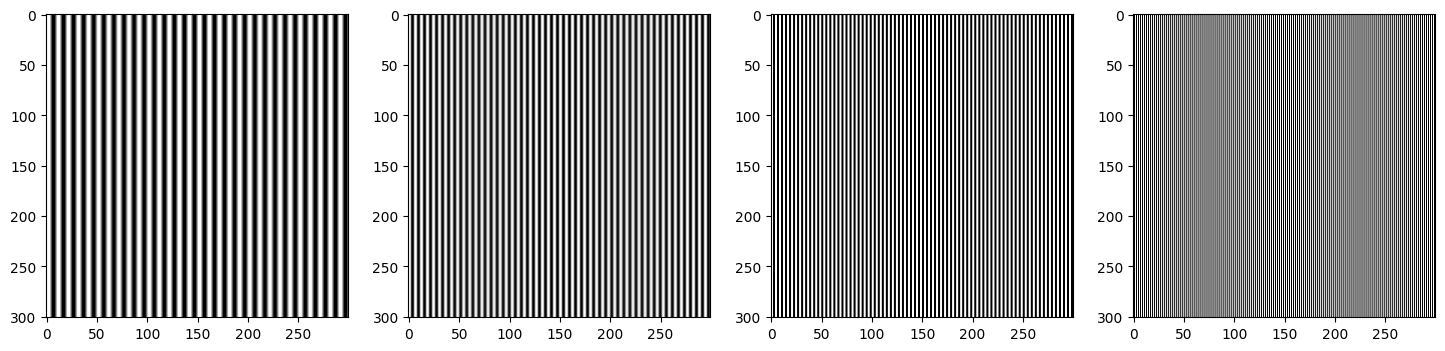

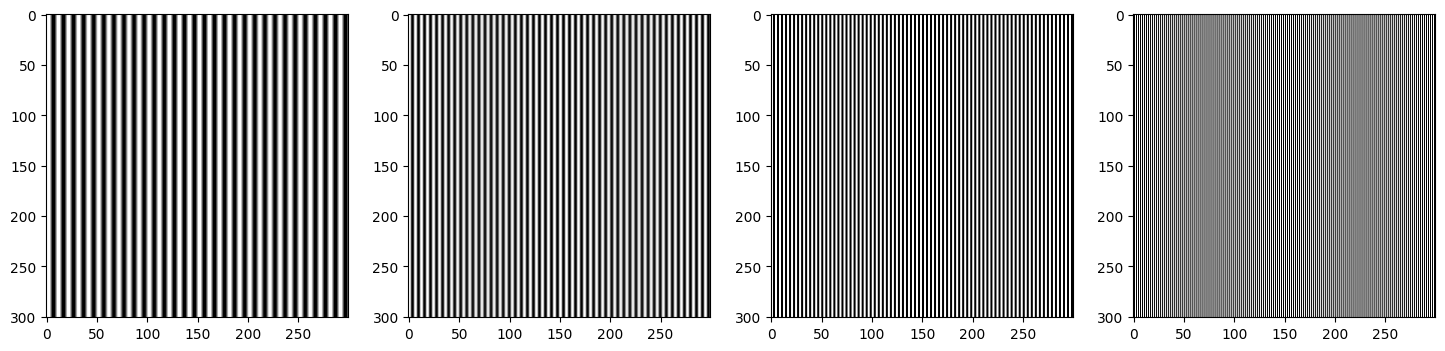

In [14]:
for lvl in lvl_quant:
    f  = plt.figure(figsize=(60,60))
    for j,i in enumerate(list_sample[:4]):
        f.add_subplot(1,13, j+1)
        plt.grid(False)
        plt.imshow(get_mat(quantize_uniform(np.array(i),quant_min=0.1, quant_max=0.9, quant_level=lvl)), cmap='gray')